# Cross-slope transect selection (circumpolar)

The Antarctic continental slope is narrow (cross-slope direction) and very long (along-slope direction). The geometry makes it challenging to visualise the deynamcs/hydrographic conditions as the area of interest is usually small on e.g. a map. Here, we are interested in e.g. the along-slope variability of the ASC and the aim is to plot different quantities on a graph that has along-slope distance on the x-axis and depth/bathymetry ("lat") on the y-axis. We cannot use latitude as the y-axis, because of the corrugated coastline. This script attempts to find multiple cross-slope transects which can be used to display the area of the ocean that is occupied by the ASC.  

The method involves finding multiple cross-slope transects between a shelf isobath (or shallow isobath) and a deep isobath.
- The isobaths are calculated in `Find_depth_contour_*_approach.ipynb`.
- The shelf isobath is along 630 m depth selected using the `*plt*` approach to ensure we are close to this value. 
- 630 m is chosen as this is close to a model st_ocean (z coordinate) value and it is a rather smooth contour. 
- The deep contour is along 2000 m depth selected using the `*mask*` approch to ensure the values are at least at the desired depth.

The different steps involve:
- Part 1: Smooth the bathymetry a lot to get rid of too complicated topography
- Part 2: Load test data
- Part 3: Find "main" transects, i.e., the grid points on an upper ("shelf") and a lower ("deep") isobath (e.g. 630 m and 2000 m). 
    - Part 3.1: Work in a for-loop. For each Nth (10th) grid cell on the shelf contour, find the nearest grid point on the lower isobath. To do so, calculate the distance for each point on the deep isobath and select the grid point that has the shortest (minimum of squared value) distance. Write down that grid cell's index.
    - Part 3.2: Go through these "main" transects by hand and change any that are wrong (explanation in code below).
- Part 4: "Filling" transects
    - Part 4.1: Fill the gaps between the main transects with "filling" transects which are evenly distributed between the available grid points between the main transects. 
    - Part 4.2: Again, check all transects by hand and change those where something went wrong / unfortunate transects.

- Part 5: Save the output of the selected indices and lat/lon values of the transects. The ouput can be loaded in a different script where a certain variable (e.g. along-slope velocity) can be interpolated onto the transects and plotted in the desired way.

Notes:
- Probably lowest resolution for the case of an 'onshore' bend in the topography (e.g. at -272.5 E)
- Resolution of transects differs in along-slope direction
- For actual transects: interpolation (might often be based on the same grid cell)
- Optional extension to coastline or a deeper contour: shortest distance for every second main transect; fill up the rest

Load modules:

In [1]:
%matplotlib inline

# Standard modules
import cosima_cookbook as cc
import matplotlib.pyplot as plt
import netCDF4 as nc
import xarray as xr
import numpy as np
from dask.distributed import Client
#from cosima_cookbook import distributed as ccd

# Optional modules
import cmocean as cm
import xarray.ufuncs as xu
import matplotlib.path as mpath
import cartopy.crs as ccrs
import xgcm
import matplotlib.colors as colors

# Ignore warnings
import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

Start a cluster with multiple cores:

In [3]:
client = Client() # n_workers=4
client

Client Scheduler: tcp://127.0.0.1:36425 Dashboard: /proxy/35565/status,Cluster Workers: 4 Cores: 8 Memory: 34.36 GB


Nominate a database from which to load the data and define an experiment:

In [4]:
# Load database
session = cc.database.create_session()
# Define experiment in database
expt = '01deg_jra55v13_ryf9091'

General information for plotting / saving data

In [5]:
fig_path = '/g/data/x77/wgh581/Figures/'
out_path = '/g/data/x77/wgh581/Post_Process/'
ft_size = 14

Test area

In [6]:
lon_min = -280
lon_max = 80

## Part 1: Smoothing of bathymetry 

In [7]:
lat_slice = slice(-80, -58)

# Import bathymetry
hu = cc.querying.getvar(expt, 'hu', session, n=1)

# Import grid cell length
dxu = cc.querying.getvar(expt, 'dxu', session, n=1)
dyu = cc.querying.getvar(expt, 'dyu', session, n=1)

# Change coordinate name
dxu.coords['ni'] = hu['xu_ocean'].values
dxu.coords['nj'] = hu['yu_ocean'].values
dyu.coords['ni'] = hu['xu_ocean'].values
dyu.coords['nj'] = hu['yu_ocean'].values
dxu = dxu.rename(({'ni':'xu_ocean', 'nj':'yu_ocean'}))
dyu = dyu.rename(({'ni':'xu_ocean', 'nj':'yu_ocean'}))

# Select latitude range
hu = hu.sel(yu_ocean=lat_slice)
hu = hu.load()
dxu = dxu.sel(yu_ocean=lat_slice)
dxu = dxu.load()
dyu = dyu.sel(yu_ocean=lat_slice)
dyu = dyu.load()

In [1]:
# Function to smooth 2d data
def running_mean_2d(in_data, N):
    """
    N: number of grid cells to smooth over
    """
    in_data = in_data.load()
    out_data = in_data.copy(deep=True)
    for yy in range(len(in_data.yu_ocean)):
        cumsum_tmp = np.nancumsum(np.insert(in_data.values[yy,:], 0, 0))
        out_data[yy,int(N/2):-int(N/2)+1] = (cumsum_tmp[N:] - cumsum_tmp[:-N]) / float(N)
    for xx in range(len(in_data.xu_ocean)):
        cumsum_tmp = np.nancumsum(np.insert(in_data.values[:,xx], 0, 0))
        out_data[int(N/2):-int(N/2)+1,xx] = (cumsum_tmp[N:] - cumsum_tmp[:-N]) / float(N)
    return out_data

In [9]:
# Call function to smooth bathymetry
hu_smooth = running_mean_2d(hu, 10)

## Part 2: Along-slope barotropic velocity

To be plotted as background (for orientation) on maps.

In [10]:
# Load velocity data
start_time = '2086-01-01'
end_time   = '2086-12-31'

u = cc.querying.getvar(expt, 'u', session, start_time=start_time, end_time=end_time, ncfile="ocean.nc")
u = u.sel(time=slice(start_time,end_time)).mean('time').sel(st_ocean=slice(0,500))
u = u.sel(yu_ocean=lat_slice) 
v = cc.querying.getvar(expt, 'v', session, start_time=start_time, end_time=end_time, ncfile="ocean.nc")
v = v.sel(time=slice(start_time,end_time)).mean('time').sel(st_ocean=slice(0,500))
v = v.sel(yu_ocean=lat_slice) 

In [11]:
# import edges of st_ocean and add lat/lon dimensions:
st_edges_ocean = cc.querying.getvar(expt, 'st_edges_ocean', session, start_time=start_time, end_time=end_time, n=1)
st_edges_array = st_edges_ocean.expand_dims({'yu_ocean':u.yu_ocean,'xu_ocean':u.xu_ocean}, axis=[1,2])

# adjust edges at bottom for partial thickness:
st_edges_with_partial = st_edges_array.where(st_edges_array<hu, other=hu)
thickness = st_edges_with_partial.diff(dim='st_edges_ocean')

# change coordinate of thickness to st_ocean (needed for multipling with other variables):
st_ocean = cc.querying.getvar(expt, 'st_ocean', session, n=1)
thickness['st_edges_ocean'] = st_ocean.values
thickness = thickness.rename(({'st_edges_ocean':'st_ocean'}))
thickness = thickness.sel(st_ocean=slice(0,500))

In [12]:
# Depth average
u = (u * thickness).sum('st_ocean') / thickness.sum('st_ocean')
v = (v * thickness).sum('st_ocean') / thickness.sum('st_ocean')

Retrieve along-slope and cross-slope velocity

In [13]:
path_to_folder = '/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output000/ocean/'
grid = xr.open_mfdataset(path_to_folder+'ocean_grid.nc', combine='by_coords')

ds = xr.merge([hu, grid])
ds.coords['xt_ocean'].attrs.update(axis='X')
ds.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5)
ds.coords['yt_ocean'].attrs.update(axis='Y')
ds.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)

grid = xgcm.Grid(ds, periodic=['X'])

In [14]:
# Take gradient and move to u grid
# Simple gradient over one grid cell. 
# In latitudinal direction, we need to specify what happens at the boundary.
dhu_dx = grid.interp( grid.diff(ds.hu, 'X') / grid.interp(ds.dxu, 'X'), 'X')#, 'Y', boundary='extend')
dhu_dy = grid.interp( grid.diff(ds.hu, 'Y', boundary='extend') / grid.interp(ds.dyt, 'X'), 'Y', boundary='extend')# 'X')

# Select latitude slice
dhu_dx = dhu_dx.sel(yu_ocean=lat_slice)
dhu_dy = dhu_dy.sel(yu_ocean=lat_slice)

In [15]:
# Calculate the magnitude of the topographic slope
slope = xu.sqrt(dhu_dx**2 + dhu_dy**2)

In [16]:
# Along-slope velocity
u_along = u*dhu_dy/slope - v*dhu_dx/slope
u_along = u_along.load()

## Part 3: "Main" transects

### Part 3.1: Get transects with shortest distance between shelf and deep contour

**Load previously calculated isobath information**

The contours are calculated separately in `Find_depth_contour_*_approach.ipynb`. *being either `plt` or `mask`.

Get the lat and lon information for the isobath contour.

In [27]:
def get_lat_lon_along_contour(isobath_depth):
    file_path = '/g/data/x77/wgh581/Post_Process/Antarctic_slope_contour_smoothed_' + str(isobath_depth) + 'm.npz'
    data = np.load(file_path)
    return data['lon_along_contour'], data['lat_along_contour'], data['num_points']

def get_lat_lon_along_contour_plt_approach():
    file_path = '/g/data/x77/wgh581/Post_Process/Antarctic_slope_contour_smoothed_u_t_630m_plt_approach.npz'
    data = np.load(file_path)
    #print(data.files)
    return data['lon_along_contour_u'], data['lat_along_contour_u'], data['num_points_u']


In [722]:
lon_630, lat_630, num_points_630 = get_lat_lon_along_contour_plt_approach()

lon_650, lat_650, num_points_650 = get_lat_lon_along_contour(650)
lon_800, lat_800, num_points_800 = get_lat_lon_along_contour(800)
lon_1000, lat_1000, num_points_1000 = get_lat_lon_along_contour(1000)
lon_1500, lat_1500, num_points_1500 = get_lat_lon_along_contour(1500)
lon_2000, lat_2000, num_points_2000 = get_lat_lon_along_contour(2000)
lon_2500, lat_2500, num_points_2500 = get_lat_lon_along_contour(2500)

Plot the depth contours on a map (along-slope velocity as background shading)

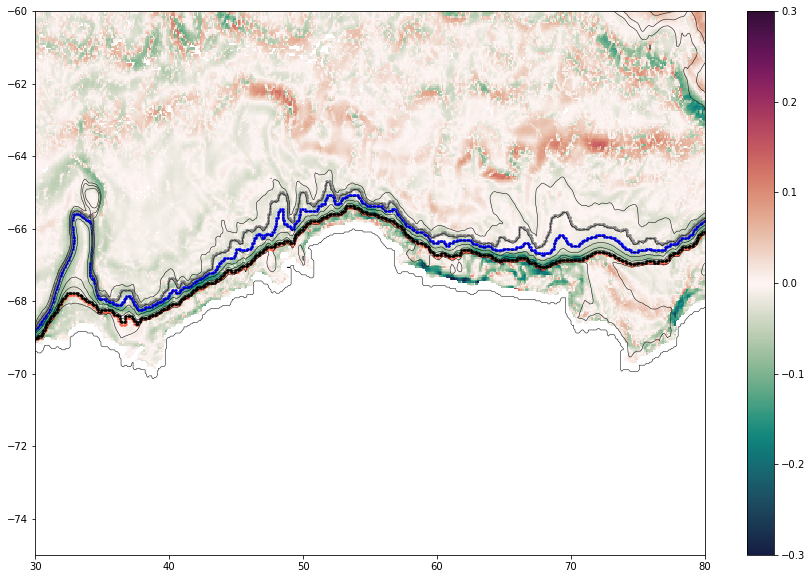

In [138]:
fig = plt.figure(figsize=(15,10))

sc = plt.pcolormesh(u_along.xu_ocean, u_along.yu_ocean, u_along, cmap=cm.cm.curl, vmin=-0.3, vmax=0.3)
plt.contour(hu_smooth.xu_ocean, hu_smooth.yu_ocean, hu_smooth, levels=[0,500, 800, 1000, 1500, 2000, 2500, 3000], linewidths=0.5, colors='k')
plt.scatter(lon_630, lat_630, color='tomato', s=2)
plt.scatter(lon_650, lat_650, color='k', s=2)
plt.scatter(lon_2000, lat_2000, color='b', s=2)
plt.scatter(lon_2500, lat_2500, color='0.5', s=2)
xx = 2500
plt.scatter(lon_630[xx], lat_630[xx], color='crimson', s=20)
plt.scatter(lon_630[xx+1], lat_630[xx+1], color='crimson', s=20, marker='+')
plt.scatter(lon_630[xx-1], lat_630[xx-1], color='crimson', s=20, marker='_')
plt.ylim(-75,-60)
#plt.xlim(lon_min, lon_max)
plt.xlim(30, 80)
plt.colorbar(sc);

#### Remove some loops/troughs in the 630 m contour

In [723]:
# Get rid of some cells in the trough
lon_630  = np.delete(lon_630,  np.arange(297, 361, 1))
lat_630  = np.delete(lat_630,  np.arange(297, 361, 1))
lon_630  = np.delete(lon_630,  np.arange(370, 389, 1))
lat_630  = np.delete(lat_630,  np.arange(370, 389, 1))
lon_630  = np.delete(lon_630,  np.arange(962, 982, 1))
lat_630  = np.delete(lat_630,  np.arange(962, 982, 1))
lon_630  = np.delete(lon_630,  np.arange(1770, 1846, 1))
lat_630  = np.delete(lat_630,  np.arange(1770, 1846, 1))
lon_630  = np.delete(lon_630,  np.arange(2030, 2068, 1))
lat_630  = np.delete(lat_630,  np.arange(2030, 2068, 1))

Select area of interest

In [724]:
# Select area of interest
index_630  = np.where((lon_630>lon_min) & (lon_630<lon_max))
Lon_630    = lon_630[index_630]
Lat_630    = lat_630[index_630]

index_2000 = np.where((lon_2000>lon_min) & (lon_2000<lon_max))
Lon_2000   = lon_2000[index_2000]
Lat_2000   = lat_2000[index_2000]

In [725]:
# Get main transect for each Nth grid cell on the shelf isobath
N = 10
Lon_shelf = Lon_630[::N]
Lat_shelf = Lat_630[::N]
shelf_index = np.arange(0, len(Lat_630), 1)
shelf_index = shelf_index[::N]

**Define functions**

Function to calculate distance between two points on lat/lon grid

In [143]:
def gcdist(lat1, lat2, lon1, lon2):

    # Radius of the Earth in km
    r = 6371
    # Difference between points (lon/lat)
    dlon = lon2-lon1
    dlat = lat2-lat1
    # Calculate distance in km
    gcdist = r * np.deg2rad(np.sqrt(dlat**2 + (dlon*np.cos(np.deg2rad(np.mean([lat1,lat2]))))**2))

    return gcdist

Function to select indices for transects on the deeper isobath

In [144]:
# Find lat/lon on deep isobath that has shortest distance to shelf isobath 
# (we want a pair of lat/lon on the deep isobath for each pair of lat/lon on the shelf isobath)

def get_index(lon_deep, lat_deep):
    
    # Loop through the shelf isobath
    dist_index = np.zeros(len(Lon_shelf))
    for ii in range(len(Lon_shelf)):
        dist_tmp = np.zeros(len(lon_deep))
        for jj in range(len(lon_deep)):
            dist_tmp[jj] = gcdist(Lat_shelf[ii], lat_deep[jj], Lon_shelf[ii], lon_deep[jj])
        dist_index_tmp = np.argmin(dist_tmp**2)
        dist_index[ii] = dist_index_tmp
        #Lat_2000_T[ii] = lat_2000[dist_index_tmp]
        #Lon_2000_T[ii] = lon_2000[dist_index_tmp]

    # No we can check for duplicates or values that cross other transects
    diff_dist_index = np.diff(dist_index)
    flag_index = []
    for ii in range(len(diff_dist_index)):
        if diff_dist_index[ii] == 0:
            # Transects meet at the same grid cell on the deeper isobath
            # Move the index closer to the 'start' (going from -280E to 80E) one closer,
            # but only if that grid cell is free
            if dist_index[ii] != dist_index[ii]-1:
                dist_index[ii] = dist_index[ii]-1
    
    # Multiple transects meet at the same grid cell on the deeper isobath
    # We do the above again for the case when more than 2 transects meet at the same grid cell or when the above led to new duplicates. 
    # This should capture a few more points.
    diff_dist_index = np.diff(dist_index)
    for ii in range(len(diff_dist_index)):
        if diff_dist_index[ii] == 0:
            if dist_index[ii] != dist_index[ii]-1:
                dist_index[ii] = dist_index[ii]-1
                
    ## Identify areas that might be more problematic
    #for ii in range(len(diff_dist_index)):
    #    if diff_dist_index[ii] < 0:
    #        # Transect goes further back (closer to the 'start')
    #        # Simple note them down and we deal with the problem later (check by hand each location)
    #        flag_index = np.append(flag_index, dist_index[ii])
            
    # Finished
    return dist_index#, flag_index

Now find the shortest distance pair for each point on the shelf isobath (call above functions)

In [726]:
%%time
# Call function for deep contour of choice
# Here: shelf contour is 630 m, deep contour is 2000 m, bathymetry smoothing is over 10 grid cells, main transects are for every 10th grid cell on shelf contour
# This part of the code take a little while to run, but is not too bad (approximately 1 min).
dist_index = get_index(lon_2000, lat_2000)

CPU times: user 54.1 s, sys: 317 ms, total: 54.4 s
Wall time: 54 s


### Part 3.2: Manually change a few transects 

This part is tedious as you need to go along the coastline and look for transects that are not optimal: 
- troughs or hills sometimes favour a transect to the wrong side.
- get rid of any transects that overlap each other
- if some part of the flow is obviously missing

Note: This depends on the contours chosen and hence needs to be adapted for a different configuration.  
(i.e. different bathymetry smoothing or depth contour selection)

**Shelf contour: 630 m, Deep contour: 2000 m**

N = 10, bathymetry smoothing of 10 grid cells

Change the index of the deep contour:

In [727]:
# Get rid of some cells in the trough
dist_index  = np.delete(dist_index, [76, 77, 78, 79])
Lon_shelf   = np.delete(Lon_shelf,  [76, 77, 78, 79])
Lat_shelf   = np.delete(Lat_shelf,  [76, 77, 78, 79])
shelf_index = np.delete(shelf_index, [76, 77, 78, 79])

In [728]:
dist_index[253] = 3650
dist_index[254] = 3669

Now we can finally select the lat/lon values based on the indices found above.

In [729]:
Lat_deep_T = np.zeros(len(dist_index))
Lon_deep_T = np.zeros(len(dist_index))
for ii in range(len(dist_index)):
    Lat_deep_T[ii] = lat_2000[int(dist_index[ii])]
    Lon_deep_T[ii] = lon_2000[int(dist_index[ii])]

Plot the transects and zoom to region (you will have to change the xlim/ylim values to go all the way along the coastline).

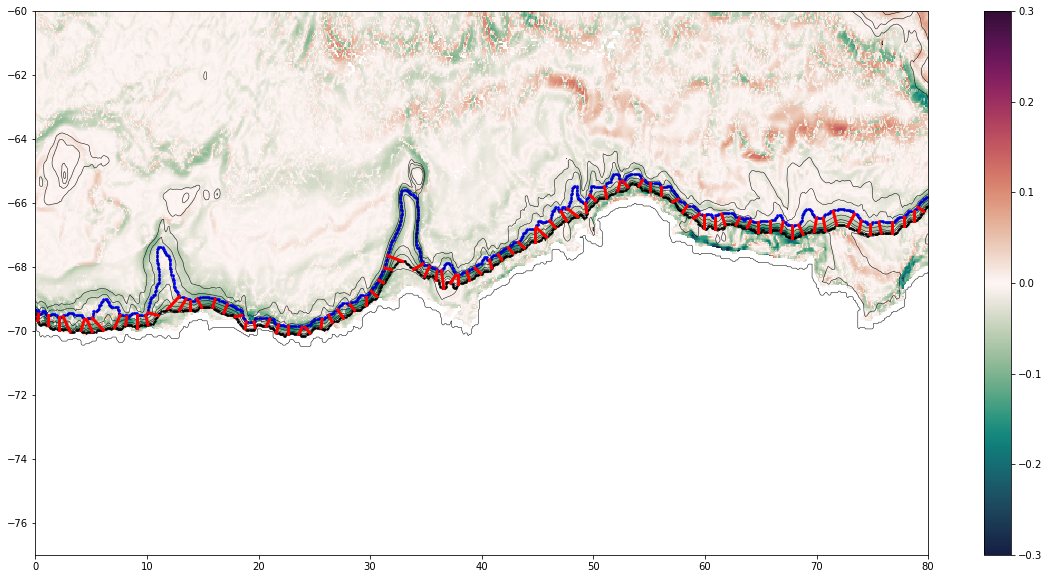

In [246]:
fig = plt.figure(figsize=(20,10))

sc = plt.pcolormesh(u_along.xu_ocean, u_along.yu_ocean, u_along, cmap=cm.cm.curl, vmin=-0.3, vmax=0.3)
plt.contour(hu_smooth.xu_ocean, hu_smooth.yu_ocean, hu_smooth, levels=[0, 500, 800, 1000, 1500, 2000, 2500, 3000], linewidths=0.5, colors='k')
plt.scatter(lon_630, lat_630, color='k', s=2)
plt.scatter(lon_2000, lat_2000, color='b', s=2)
#plt.scatter(lon_2500, lat_2500, color='0.5', s=2)
# Plot transects
for ii in range(len(Lon_shelf)):
    plt.plot([Lon_shelf[ii], Lon_deep_T[ii]], [Lat_shelf[ii], Lat_deep_T[ii]], color='r', linewidth=3)
xx = 254
plt.plot([Lon_shelf[xx], Lon_deep_T[xx]], [Lat_shelf[xx], Lat_deep_T[xx]], color='c', linewidth=3)
plt.ylim(-77,-60)
plt.xlim(-0,80)
plt.colorbar(sc);

These few lines helped me to find the indices that I want to change:

In [212]:
np.argmin((Lon_deep_T+52)**2)

262

In [221]:
Lat_deep_T[253]

-60.714092384400836

In [223]:
dist_index[253:255]

array([3603., 3751.])

In [224]:
dist_index[253]

3603.0

Indices to move  
dist_index[146] = 1584

## Part 4: Find evenly distributed values between every N$^{th}$ transect

In this second step, find evenly distributed transects between the transects found in step 1. The idea is that this approach gives us a more even distribution of transects. Then check all the transects and change by hand the bad transects.

In [377]:
# shelf_index: indices of positions of main transects on shelf contour
#shelf_index = np.arange(0, len(Lat_630), 1)
#shelf_index = shelf_index[::N]

In [ ]:
# This comes from the selection by hand and is specific for the chosen depth contours and smoothing:
#shelf_index = np.delete(shelf_index, [102, 103, 104, 105, 109, 111]) 

### Part 4.1: Get the filling transects

Now find the indices for the points on the shelf and deep depth contour of the evenly distributed "filling" transects.  
- The idea is to go through each subset of data points between the transects found in step 1. 
- Check if there are more data points on the shelf or deep depth contour. 
- The number of additional transects is given by the free grid points on the contour that has less. Evenly distribute the data points on the contour with more points.

In [730]:
# THIS CODE IS NOT THE NICEST, BUT WORKS... 

index_deep  = []
index_shelf = []

for ii in range(len(dist_index)-1):
    
    index_deep_tmp  = np.arange(dist_index[ii],  dist_index[ii+1], 1)
    index_shelf_tmp = np.arange(shelf_index[ii], shelf_index[ii+1], 1)
    
    if len(index_deep_tmp) <= 0:
        # don't do anything if two transects end at the same point on deep contour
        loop = 0
        continue
        
    elif len(index_deep_tmp) == len(index_shelf_tmp):
        # use every index when the number of points between two transect exactly match
        loop = 1
        index_deep  = np.append(index_deep, index_deep_tmp)
        index_shelf = np.append(index_shelf, index_shelf_tmp)
        
    elif (len(index_deep_tmp) > 0) & (len(index_deep_tmp) < len(index_shelf_tmp)):
        # there are less points between transects on the deeper contour
        loop = 2
        index_deep = np.append(index_deep, index_deep_tmp)
        NN = len(index_shelf_tmp)
        nn = len(index_deep_tmp)
        if NN == 10:
            if nn == 1:
                a = 10
                tmp = index_shelf_tmp[0]
            if nn == 2:
                good_objects = [True, False, False, False, False, True, False, False, False, False]
                tmp = [a for (a, truth) in zip(index_shelf_tmp, good_objects) if truth]
            elif nn == 3:
                good_objects = [True, False, False, True, False, False, True, False, False, False]
                tmp = [a for (a, truth) in zip(index_shelf_tmp, good_objects) if truth]
            elif nn == 4:
                good_objects = [True, False, False, True, False, False, True, False, True, False]
                tmp = [a for (a, truth) in zip(index_shelf_tmp, good_objects) if truth]
            elif nn == 5:
                good_objects = [True, False, True, False, True, False, True, False, True, False]
                tmp = [a for (a, truth) in zip(index_shelf_tmp, good_objects) if truth]
            elif nn == 6:
                good_objects = [True, False, True, False, True, True, True, False, True, False]
                tmp = [a for (a, truth) in zip(index_shelf_tmp, good_objects) if truth]
            elif nn == 7:
                good_objects = [True, True, False, True, True, False, True, True, False, True]
                tmp = [a for (a, truth) in zip(index_shelf_tmp, good_objects) if truth]
            elif nn == 8:
                good_objects = [True, True, True, False, True, True, True, False, True, True]
                tmp = [a for (a, truth) in zip(index_shelf_tmp, good_objects) if truth]
            elif nn == 9:
                good_objects = [True, True, True, True, True, False, True, True, True, True]
                tmp = [a for (a, truth) in zip(index_shelf_tmp, good_objects) if truth]
        elif NN == 20:
            divider = int(NN/nn)
            tmp = index_shelf_tmp[::divider]
        elif NN == 50:
            #divider = int(NN/nn)
            #tmp = index_shelf_tmp[::divider]
            good_objects = [True, False, True, True, False, True, True, False, True, False, True, False, True, True, False, False, True, False, \
                            True, True, False, True, True, False, True, True, False, True, True, False, True, True, False, True, False, True, \
                            False, True, False, True, False, True, True, False, True, False, True, False, True, True]
            tmp = [a for (a, truth) in zip(index_shelf_tmp, good_objects) if truth]
            
        index_shelf = np.append(index_shelf, tmp)
        
    elif len(index_deep_tmp) > len(index_shelf_tmp):
        # there are more points between transects on the deeper contour
        loop = 3
        index_shelf = np.append(index_shelf, index_shelf_tmp)
        nn = len(index_deep_tmp)
        if nn == 11:
            tmp = index_deep_tmp[:-1]
        elif nn == 12:
            tmp = list(index_deep_tmp)
            del tmp[::6]
        elif nn == 13:
            tmp = list(index_deep_tmp)
            del tmp[::5]
        elif nn == 14:
            good_objects = [True, True, True, False, True, True, True, False, True, True, \
                           True, False, True, False]
            tmp = [a for (a, truth) in zip(index_deep_tmp, good_objects) if truth]
        elif nn == 15:
            tmp = list(index_deep_tmp)
            del tmp[::3]
        elif nn == 16: 
            good_objects = [True, True, False, True, True, False, True, False, True, False, \
                           True, True, False, True, True, False]
            tmp = [a for (a, truth) in zip(index_deep_tmp, good_objects) if truth]
        elif nn == 17:
            good_objects = [True, False, True, False, True, False, True, False, \
                           True, True, True, False, True, False, True, False, True]
            tmp = [a for (a, truth) in zip(index_deep_tmp, good_objects) if truth]
        elif nn == 18:
            good_objects = [True, True, False, True, False, True, False, True, False, \
                           True, True, False, True, False, True, False, True, False]
            tmp = [a for (a, truth) in zip(index_deep_tmp, good_objects) if truth]
        elif nn == 19:
            tmp = index_deep_tmp[::2]
        elif nn == 20:
            tmp = list(index_deep_tmp)
            del tmp[::2]
        elif nn == 21:
            tmp = index_deep_tmp[::2][:-1]
        elif nn == 22:
            good_objects = [True, False, True, False, True, False, True, False, False, True, False, True, False, False, \
                           True, False, True, False, True, False, True, False]
            tmp = [a for (a, truth) in zip(index_deep_tmp, good_objects) if truth]
        elif nn == 23:
            tmp = index_deep_tmp[1::2]
            tmp = tmp[:-1]
        elif nn == 24:
            good_objects = [True, False, False, True, False, False, True, False, True, False, True, False, True, False, True, \
                           False, False, True, False, False, True, False, True, False]
            tmp = [a for (a, truth) in zip(index_deep_tmp, good_objects) if truth]
        elif nn == 25:
            good_objects = [True, False, False, True, False, False, True, False, True, False, True, False, True, False, True, \
                           False, False, True, False, False, True, False, True, False, False]
            tmp = [a for (a, truth) in zip(index_deep_tmp, good_objects) if truth]
        elif nn == 26: 
            good_objects = [True, False, False, True, False, False, True, False, False, True, False, True, False, True, False, \
                           True, False, False, True, False, False, True, False, False, True, False]
            tmp = [a for (a, truth) in zip(index_deep_tmp, good_objects) if truth]
        elif nn == 27:
            good_objects = [True, False, False, True, False, False, True, False, False, True, False, False, \
                            True, False, False, True, False, False, True, False, False, True, False, False, \
                            True, False, True]
            tmp = [a for (a, truth) in zip(index_deep_tmp, good_objects) if truth]
        elif nn in (28, 29, 30):
            tmp = index_deep_tmp[0::3]
        elif nn == 31:
            tmp = index_deep_tmp[1::3]
        elif nn == 32:
            good_objects = [True, False, False, False, True, False, False, True, False, False, True, False, False, \
                            True, False, False, True, False, False, True, False, False, True, False, False, \
                            True, False, False, True, False, False, False]
            tmp = [a for (a, truth) in zip(index_deep_tmp, good_objects) if truth]
        elif nn == 33:
            good_objects = [True, False, False, False, True, False, False, False, True, False, False, True, \
                            False, False, True, False, False, True, False, False, True, False, False, True, False, \
                            False, True, False, False, True, False, False, False]
            tmp = [a for (a, truth) in zip(index_deep_tmp, good_objects) if truth]
        elif nn == 35:
            good_objects = [True, False, False, False, True, False, False, False, True, False, False, False, \
                            True, False, False, True, False, False, True, False, False, True, False, False, \
                            True, False, False, True, False, False, False, True, False, False, False]
            tmp = [a for (a, truth) in zip(index_deep_tmp, good_objects) if truth]
        elif nn in (36, 37):
            tmp = np.append(index_deep_tmp[1::4], index_deep_tmp[-1])
        elif nn in (38, 39, 40):
            tmp = index_deep_tmp[0::4]
        elif nn in (41, 42, 43):
            tmp = index_deep_tmp[0::4][:-1]
        elif nn == 45:
            tmp = index_deep_tmp[0::5]
            tmp = np.append(tmp, index_deep_tmp[-2])
        elif nn in (47, 48, 49):
            tmp = index_deep_tmp[0::5]
        elif nn in (51, 52, 53):
            tmp = index_deep_tmp[0::5][:-1]
        elif nn in (56, 57):
            tmp = index_deep_tmp[0::6]
        elif nn == 62:
            tmp = index_deep_tmp[0::6][:-1]
        elif nn in (66, 68, 69, 70):
            tmp = index_deep_tmp[::7]
        elif nn == 72:
            tmp = index_deep_tmp[::7][:-1]
        elif nn == 80:
            tmp = index_deep_tmp[::8]
        elif nn == 81:
            tmp = index_deep_tmp[::8][:-1]
        elif nn == 106:
            tmp = index_deep_tmp[::10]
            tmp = tmp[1:]
        elif nn in(101, 104, 107):
            tmp = index_deep_tmp[::11]
        elif nn in (113, 118, 120):
            tmp = index_deep_tmp[::12]
        elif nn == 136:
            tmp = index_deep_tmp[::14]
        elif nn == 149:
            tmp = index_deep_tmp[::15]
        elif nn == 153:
            tmp = index_deep_tmp[::16]

        index_deep = np.append(index_deep, tmp)
    
    # Check if there is a problem with the code
    if len(index_deep) != len(index_shelf):
        print('')
        print('Something went wrong at ii = %i'%ii)
        print('len(index_deep):', len(index_deep_tmp))
        print('len(index_shallow):', len(index_shelf_tmp))
        print('loop =', loop)
        print('nn:', nn)
        print('NN: ', NN)
        print('tmp=', tmp)
        break


In [286]:
test = np.linspace(1, 118, 118)
test[::12]#[:-1]

array([  1.,  13.,  25.,  37.,  49.,  61.,  73.,  85.,  97., 109.])

### Part 4.2: Again, change by hand bad transects

Change the indices

In [731]:
index_deep[166] = 256

In [732]:
index_deep = np.delete(index_deep, [294])
index_shelf = np.delete(index_shelf, [294])
index_deep = np.delete(index_deep, [294])
index_shelf = np.delete(index_shelf, [294])
index_deep = np.delete(index_deep, [294])
index_shelf = np.delete(index_shelf, [294])

In [733]:
index_deep[294] = 654
index_deep[295] = 656
index_deep[296] = 659

In [734]:
index_deep = np.delete(index_deep, [340])
index_shelf = np.delete(index_shelf, [340])

In [735]:
index_deep = np.delete(index_deep, np.arange(597, 616, 1))
index_shelf = np.delete(index_shelf, np.arange(597, 616, 1))

In [736]:
index_deep[811] = 1494
index_deep[812] = 1497
index_deep[813] = 1499
index_deep[830] = 1534
index_deep[831] = 1537
index_deep[832] = 1539
index_deep[833] = 1546
index_deep[837] = 1632
index_deep[838] = 1635
index_deep[873] = 1683

In [737]:
index_deep = np.delete(index_deep, np.arange(2087, 2092, 1))
index_shelf = np.delete(index_shelf, np.arange(2087, 2093, 1))

In [738]:
index_shelf[2718] = 3339
index_shelf[2719] = 3341
index_shelf[2720] = 3343
index_shelf[2721] = 3344

index_deep[2732] = 4803
index_deep[2733] = 4804
index_deep[2734] = 4805
index_deep[2735] = 4806
index_deep[2736] = 4850
index_deep[2737] = 4851
index_deep[2738] = 4852
index_deep[2739] = 4854
index_deep[2740] = 4856
index_deep[2741] = 4858

index_deep[2873] = 5105
index_deep[2874] = 5107
index_deep[2875] = 5109

index_deep[3076] = 5480
index_deep[3077] = 5495
index_deep[3078] = 5510
index_deep[3079] = 5548
index_deep[3080] = 5570
index_deep[3081] = 5580
index_deep[3082] = 5590
index_deep[3083] = 5600
index_deep[3084] = 5608
index_deep[3085] = 5613

index_deep[3220] = 5832
index_deep[3221] = 5834
index_deep[3222] = 5836
index_deep[3223] = 5840
index_deep[3224] = 5847
index_deep[3225] = 5868
index_deep[3226] = 5869
index_deep[3227] = 5871
index_deep[3228] = 5872
index_deep[3229] = 5873
index_deep[3230] = 5875
index_deep[3231] = 5877

Add transects to the last section (missing because of lon shift)

In [697]:
#index_deep_add  = [6327, 6329, 6330, 6332, 6333, 6334, 6336, 6339]#, 6340, 6343]
#index_shelf_add = np.arange(4248, 4256, 1)
#index_deep  = np.append(index_deep, index_deep_add)
#index_shelf = np.append(index_shelf, index_shelf_add)

In [766]:
#print(len(index_shelf))
#print(len(index_deep))
# In this case (not sure why) index_shelf != index_deep
index_shelf = np.append(index_shelf, 4250)
# Now add 4 more transects
index_deep_add  = [6330, 6334, 6338, 6341]
index_shelf_add = np.arange(4251, 4255, 1)
index_deep  = np.append(index_deep, index_deep_add)
index_shelf = np.append(index_shelf, index_shelf_add)

3516
3516


Now select the latitude and longitude values from the indices found above.

In [777]:
lat_deep  = np.zeros(len(index_deep))
lon_deep  = np.zeros(len(index_deep))
lat_shelf = np.zeros(len(index_shelf))
lon_shelf = np.zeros(len(index_shelf))
for ii in range(len(index_deep)):
    lat_deep[ii] = Lat_2000[int(index_deep[ii])]
    lon_deep[ii] = Lon_2000[int(index_deep[ii])]
for ii in range(len(index_shelf)):
    lat_shelf[ii] = Lat_630[int(index_shelf[ii])]
    lon_shelf[ii] = Lon_630[int(index_shelf[ii])]

Plot the transects on a map. Zoom (by changing the xlim/ylim values) to different regions going all the way around the coastline. Check if the transects look okay.

distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


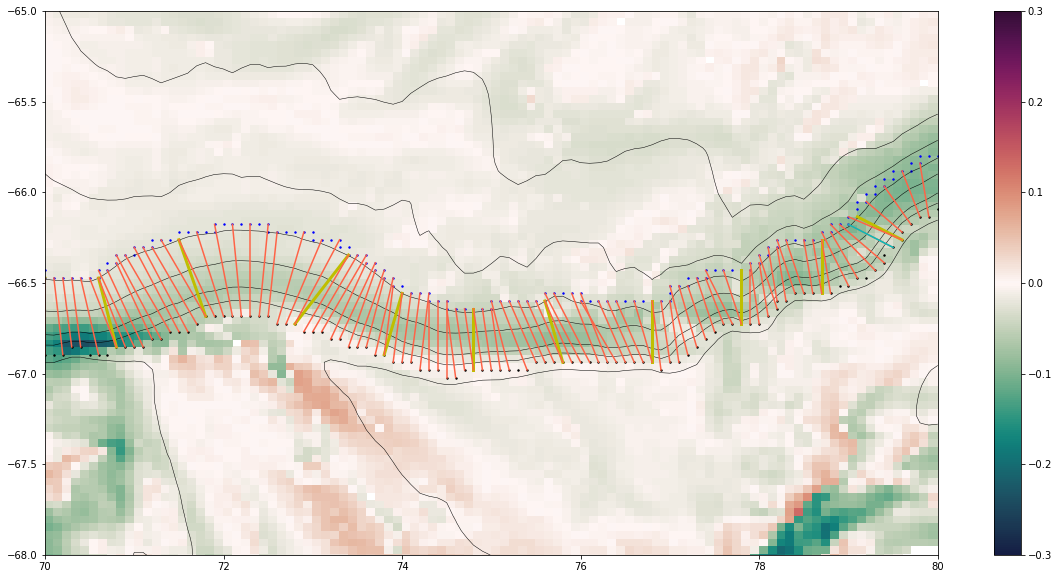

In [778]:
fig = plt.figure(figsize=(20,10))

sc = plt.pcolormesh(u_along.xu_ocean, u_along.yu_ocean, u_along, cmap=cm.cm.curl, vmin=-0.3, vmax=0.3)
plt.contour(hu_smooth.xu_ocean, hu_smooth.yu_ocean, hu_smooth, levels=[0, 500, 800, 1000, 1500, 2000, 2500, 3000], linewidths=0.5, colors='k')
plt.scatter(lon_630, lat_630, color='k', s=2)
plt.scatter(lon_2000, lat_2000, color='b', s=2)
#plt.scatter(lon_2500, lat_2500, color='0.5', s=2)
# Plot main transects
for ii in range(len(Lon_shelf)):
    plt.plot([Lon_shelf[ii], Lon_deep_T[ii]], [Lat_shelf[ii], Lat_deep_T[ii]], color='y', linewidth=3)
# Plot filling transects
for ii in range(len(index_shelf)):
    plt.plot([lon_shelf[ii], lon_deep[ii]], [lat_shelf[ii], lat_deep[ii]], color='tomato')
xx = 3514
plt.plot([lon_shelf[xx], lon_deep[xx]], [lat_shelf[xx], lat_deep[xx]], color='c')
plt.ylim(-68, -65)
plt.xlim(70, 80)
plt.colorbar(sc);

Again, these few lines helped me in finding the indices of the bad transects.

In [686]:
np.argmin((lon_deep-79)**2)

3513

In [177]:
lat_deep[3970]

-65.2899934628634

In [751]:
index_deep[-1]

6326.0

In [748]:
print(index_deep[3515])
print(index_deep[3514])

6326.0
6325.0


In [747]:
print(index_shelf[3513])
print(index_shelf[3514])
#index_shelf[3514:]

4247.0
4249.0


### Part 5: Last, but not least...

### Part 5.1: Plot the final transects

In [779]:
theta  = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts  = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

In [780]:
# Data required for lat/lon mapping and bathymetry contours
land_mask = np.squeeze(hu.values)
land_mask = land_mask * 0
land_mask[np.isnan(land_mask)] = 1
yu_ocean = hu.yu_ocean.values
xu_ocean = hu.xu_ocean.values
land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)
# make land go all the way to -90S:
land_mask_lat = hu.yu_ocean.values
land_mask_lat[0] = -90

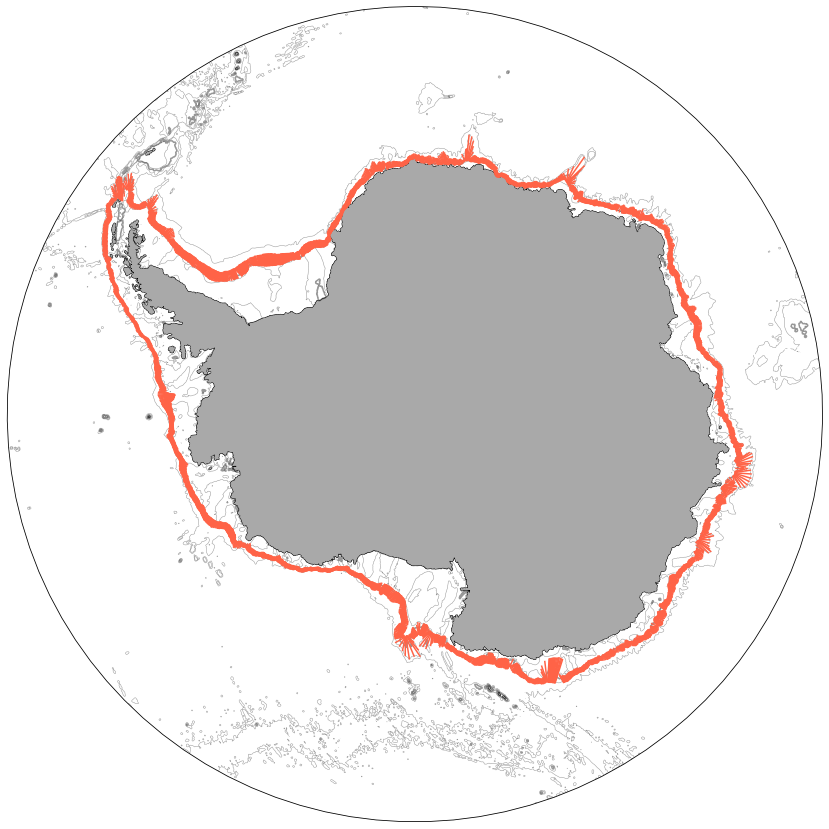

In [783]:
fig = plt.figure(1, figsize=(15,15))

for ff in range(1):
    ax0 = plt.subplot(1,1,ff+1, projection=ccrs.SouthPolarStereo())
    ax0.set_boundary(circle, transform=ax0.transAxes)
    #plt.title('Barotropic streamfunction (Sv)', fontsize=ft_size)

    # 1000 m isobath
    contour_1000m = hu.sel(yu_ocean = lat_slice)
    contour_1000m = contour_1000m.where(contour_1000m > 1000)
    contour_1000m = contour_1000m * 0 + 1
    contour_1000m = contour_1000m.fillna(0)
    
    # Plot land
    ax0.contourf(hu.xu_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2, transform = ccrs.PlateCarree())
    ax0.contour(xu_ocean, yu_ocean, land_mask, [0,1], colors = 'k', linewidths = 0.5, transform=ccrs.PlateCarree())
    ax0.contour(contour_1000m.xu_ocean, contour_1000m.yu_ocean, contour_1000m, [0,1], colors = '0.2', linewidth=1, alpha=0.5, transform = ccrs.PlateCarree())
    plt.contour(hu.xu_ocean, hu.yu_ocean, hu, levels=[500, 2000, 3000], colors='0.2', linewidths=0.5, alpha=0.5, transform = ccrs.PlateCarree())

    # Plot shelf and deep contour points
    plt.scatter(lon_650, lat_650, color='k', s=2)
    plt.scatter(lon_2000, lat_2000, color='b', s=2)
    # Plot main transects
    #for ii in range(len(Lon_shelf)):
    #    plt.plot([Lon_shelf[ii], Lon_deep_T[ii]], [Lat_shelf[ii], Lat_deep_T[ii]], color='r', linewidth=3, transform = ccrs.PlateCarree())
    # Plot filling transects
    for ii in range(len(index_deep)):
        plt.plot([lon_shelf[ii], lon_deep[ii]], [lat_shelf[ii], lat_deep[ii]], color='tomato', transform = ccrs.PlateCarree())

# Save figure
print_fig = 1
if print_fig == 1:
    fig_name = 'Fig_continental_slope_transects_circumpolar_630m_2000m.png'
    fig.savefig(fig_path + fig_name, dpi=150)

distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


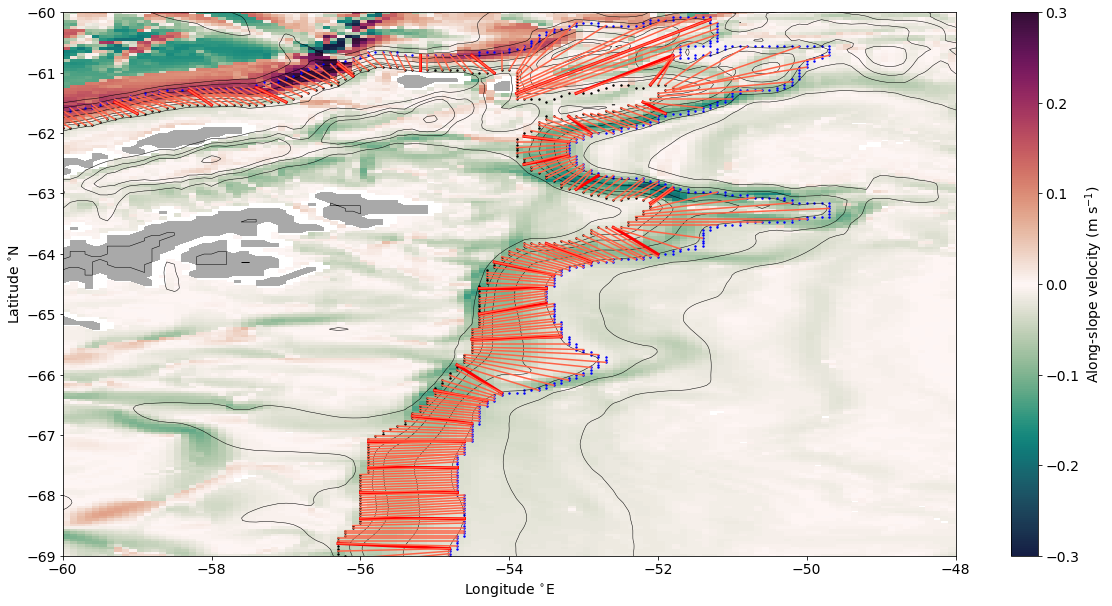

In [786]:
# Zoomed versions
# Change the xlim/ylim ranges and figure names as you like

fig = plt.figure(figsize=(20,10))

sc = plt.pcolormesh(u_along.xu_ocean, u_along.yu_ocean, u_along, cmap=cm.cm.curl, vmin=-0.3, vmax=0.3)
plt.contourf(hu.xu_ocean, land_mask_lat, land_mask_masked, colors='darkgrey')#, zorder=2, transform = ccrs.PlateCarree())
plt.contour(hu_smooth.xu_ocean, hu_smooth.yu_ocean, hu_smooth, levels=[0, 500, 800, 1000, 1500, 2000, 2500, 3000], linewidths=0.5, colors='k')
plt.scatter(lon_630, lat_630, color='k', s=2)
plt.scatter(lon_2000, lat_2000, color='b', s=2)
# Plot main transects
for ii in range(len(Lon_shelf)):
    plt.plot([Lon_shelf[ii], Lon_deep_T[ii]], [Lat_shelf[ii], Lat_deep_T[ii]], color='r', linewidth=3)#, transform = ccrs.PlateCarree())
# Plot filling transects
for ii in range(len(index_deep)):
    plt.plot([lon_shelf[ii], lon_deep[ii]], [lat_shelf[ii], lat_deep[ii]], color='tomato')#, transform = ccrs.PlateCarree())
plt.ylim(-69,-60)
#plt.xlim(lon_min, lon_max)
#plt.ylim(-66.2, -65.2)
plt.xlim(-60, -48)
cbar = plt.colorbar(sc)
cbar.set_label('Along-slope velocity (m s$^{-1}$)', fontsize=ft_size)
cbar.ax.tick_params(labelsize=ft_size)
plt.xlabel('Longitude $^{\circ}$E', fontsize=ft_size)
plt.ylabel('Latitude $^{\circ}$N', fontsize=ft_size)
plt.xticks(fontsize=ft_size)
plt.yticks(fontsize=ft_size)

# print figure (0 for no, 1 for yes)
print_fig = 0
if print_fig == 1:
    plt.savefig(fig_path + 'Fig_continental_slope_transects_testarea_3_630m_2000m.png', dpi=150)

### Part 5.3: Save the transect information

What we need is the lat/lon information. But it might also be handy to have the indices. At the moment the data are split into the main and filling transects. Put them together. Save the indices separate. (Later also add the distance between points? Or calculate that later in the script by making use of the function in this script.)

In [787]:
import os
outfile  = os.path.join(out_path,'Antarctic_slope_transects_630m_2000m.npz')  # *_info

np.savez(outfile, lon_630m=lon_shelf, lat_630m=lat_shelf, lon_2000m=lon_deep, lat_2000m=lat_deep)

#np.savez(outfile, contour_mask_numbered=data['contour_mask_numbered'], 
#    contour_masked_above=data['contour_masked_above'], contour_depth=data['contour_depth'],
#    xu_ocean=xu_ocean, yu_ocean=yu_ocean, num_points=num_points,
#    lon_along_contour=lon_along_contour, lat_along_contour=lat_along_contour, 
#    distance_along_contour=distance_along_contour)

In [788]:
infile = out_path + 'Antarctic_slope_transects_630m_2000m.npz'
data = np.load(infile)

In [789]:
data.files

['lon_630m', 'lat_630m', 'lon_2000m', 'lat_2000m']